# Network and Spatial Analysis
#### Author: Nathan Seiler

## 0. Import Necessary Packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import osmnx as ox
import networkx as nx

import pulp
from pulp import *

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, MultiLineString, Polygon

## 3. Create a sample network graph

#### Grab and store coordinates of Chicago Departments of Public Health

In [2]:
cdph_lexingtonSt_coord = (41.87542275191835, -87.68051207654261)

*Source: Google Maps*

#### The Lexington Street location is the only one listed on their [site](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants.html) for health inspections, so let's assume that all health inspectors leave from this one location.

In [3]:
near_west_side = ox.graph_from_place('Near West Side, Chicago, Illinois', network_type = 'drive', simplify = True)

In [4]:
origin_node = ox.get_nearest_node(near_west_side, cdph_lexingtonSt_coord)
#picking a random coordinate of an inspection in the Near West Side
destination_node = ox.get_nearest_node(near_west_side, (42.01219,-87.67472))

/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [5]:
a_star_route = nx.astar_path(near_west_side, origin_node, destination_node, weight="length")

In [6]:
near_west_side = ox.add_edge_speeds(near_west_side)

# calculate travel time (seconds) for all edges
near_west_side = ox.add_edge_travel_times(near_west_side)

edges = ox.graph_to_gdfs(near_west_side, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
motorway,328.9,82.1,14.2
motorway_link,290.2,88.5,11.8
primary,98.4,66.8,5.3
primary_link,62.5,66.8,3.4
residential,112.0,66.8,6.0
road,28.2,66.8,1.5
secondary,118.7,48.3,8.9
secondary_link,49.4,66.8,2.7
tertiary,107.5,48.3,8.0


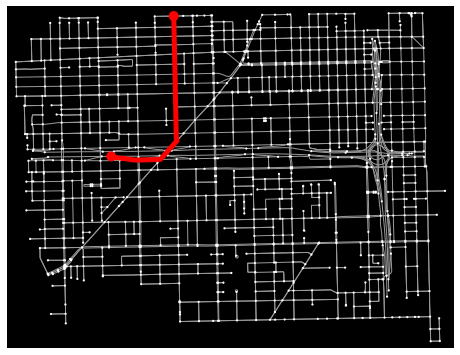

In [7]:
fig, ax = ox.plot_graph_route(near_west_side, a_star_route, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

In [8]:
dijstra_route_time=nx.dijkstra_path(near_west_side, origin_node, destination_node, weight="travel_time")

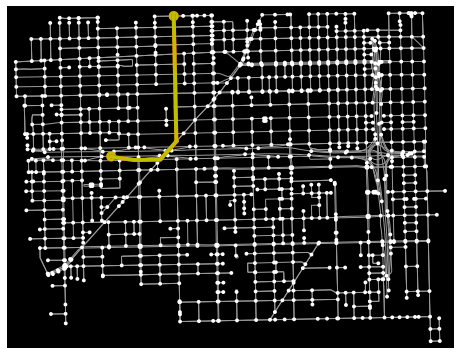

In [9]:
fig, ax = ox.plot_graph_routes(near_west_side, routes=[a_star_route,dijstra_route_time], route_colors=['r', 'y'], bgcolor='k', route_alpha=1)

In [10]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [2*60, 3*60, 5*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

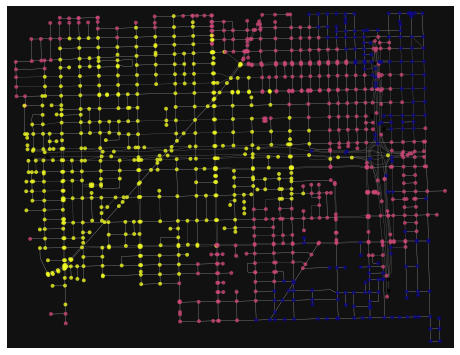

In [11]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in near_west_side.nodes()]
fig, ax = ox.plot_graph(near_west_side, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

### Let's try a larger network

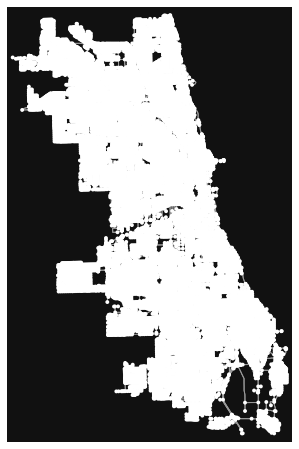

CPU times: user 53.6 s, sys: 702 ms, total: 54.3 s
Wall time: 54.6 s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [12]:
%%time

chicago = ox.graph_from_place('Chicago, Illinois', network_type='drive', simplify=True)
ox.plot_graph(chicago)

In [13]:
chicago = ox.add_edge_speeds(chicago)

# calculate travel time (seconds) for all edges
chicago = ox.add_edge_travel_times(chicago)

edges = ox.graph_to_gdfs(chicago, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['motorway_link', 'secondary_link']",174.7,83.1,7.6
"['primary', 'motorway_link']",254.9,49.2,18.6
"['residential', 'living_street']",250.3,39.2,23.0
"['residential', 'tertiary']",225.5,39.2,20.7
"['residential', 'unclassified']",386.2,39.2,35.5
"['secondary', 'motorway_link']",401.3,49.0,29.5
"['secondary', 'primary']",262.0,49.0,19.2
"['secondary', 'secondary_link']",183.7,49.0,13.5
"['secondary', 'tertiary']",144.3,49.0,10.6


In [14]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [5*60, 15*60, 30*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(chicago, origin_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

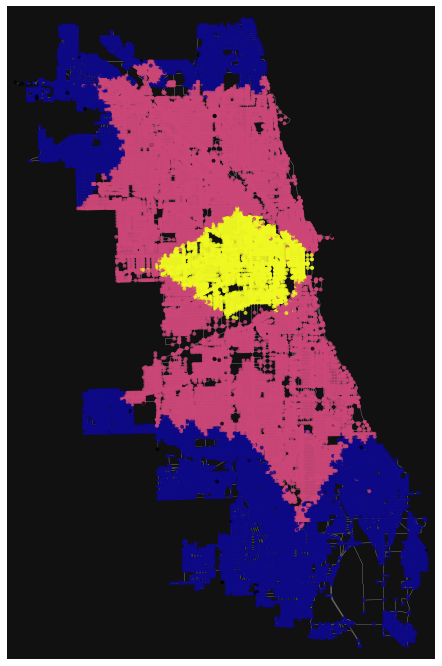

In [15]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(chicago, origin_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in chicago.nodes()]
fig, ax = ox.plot_graph(chicago, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999',figsize = (12,12))

## 4. Spatial Optimization using the P-median Problem

Let's say we would like to place a number *P* of facilities while minimizing the total weighted distance of servicing all demands. Each node has an associated weight that represents the amount of demand at that nodes, we will use population because a health department is an important community resource. 

**Objective function:** Minimizing demand-weighted summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location 

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not. 

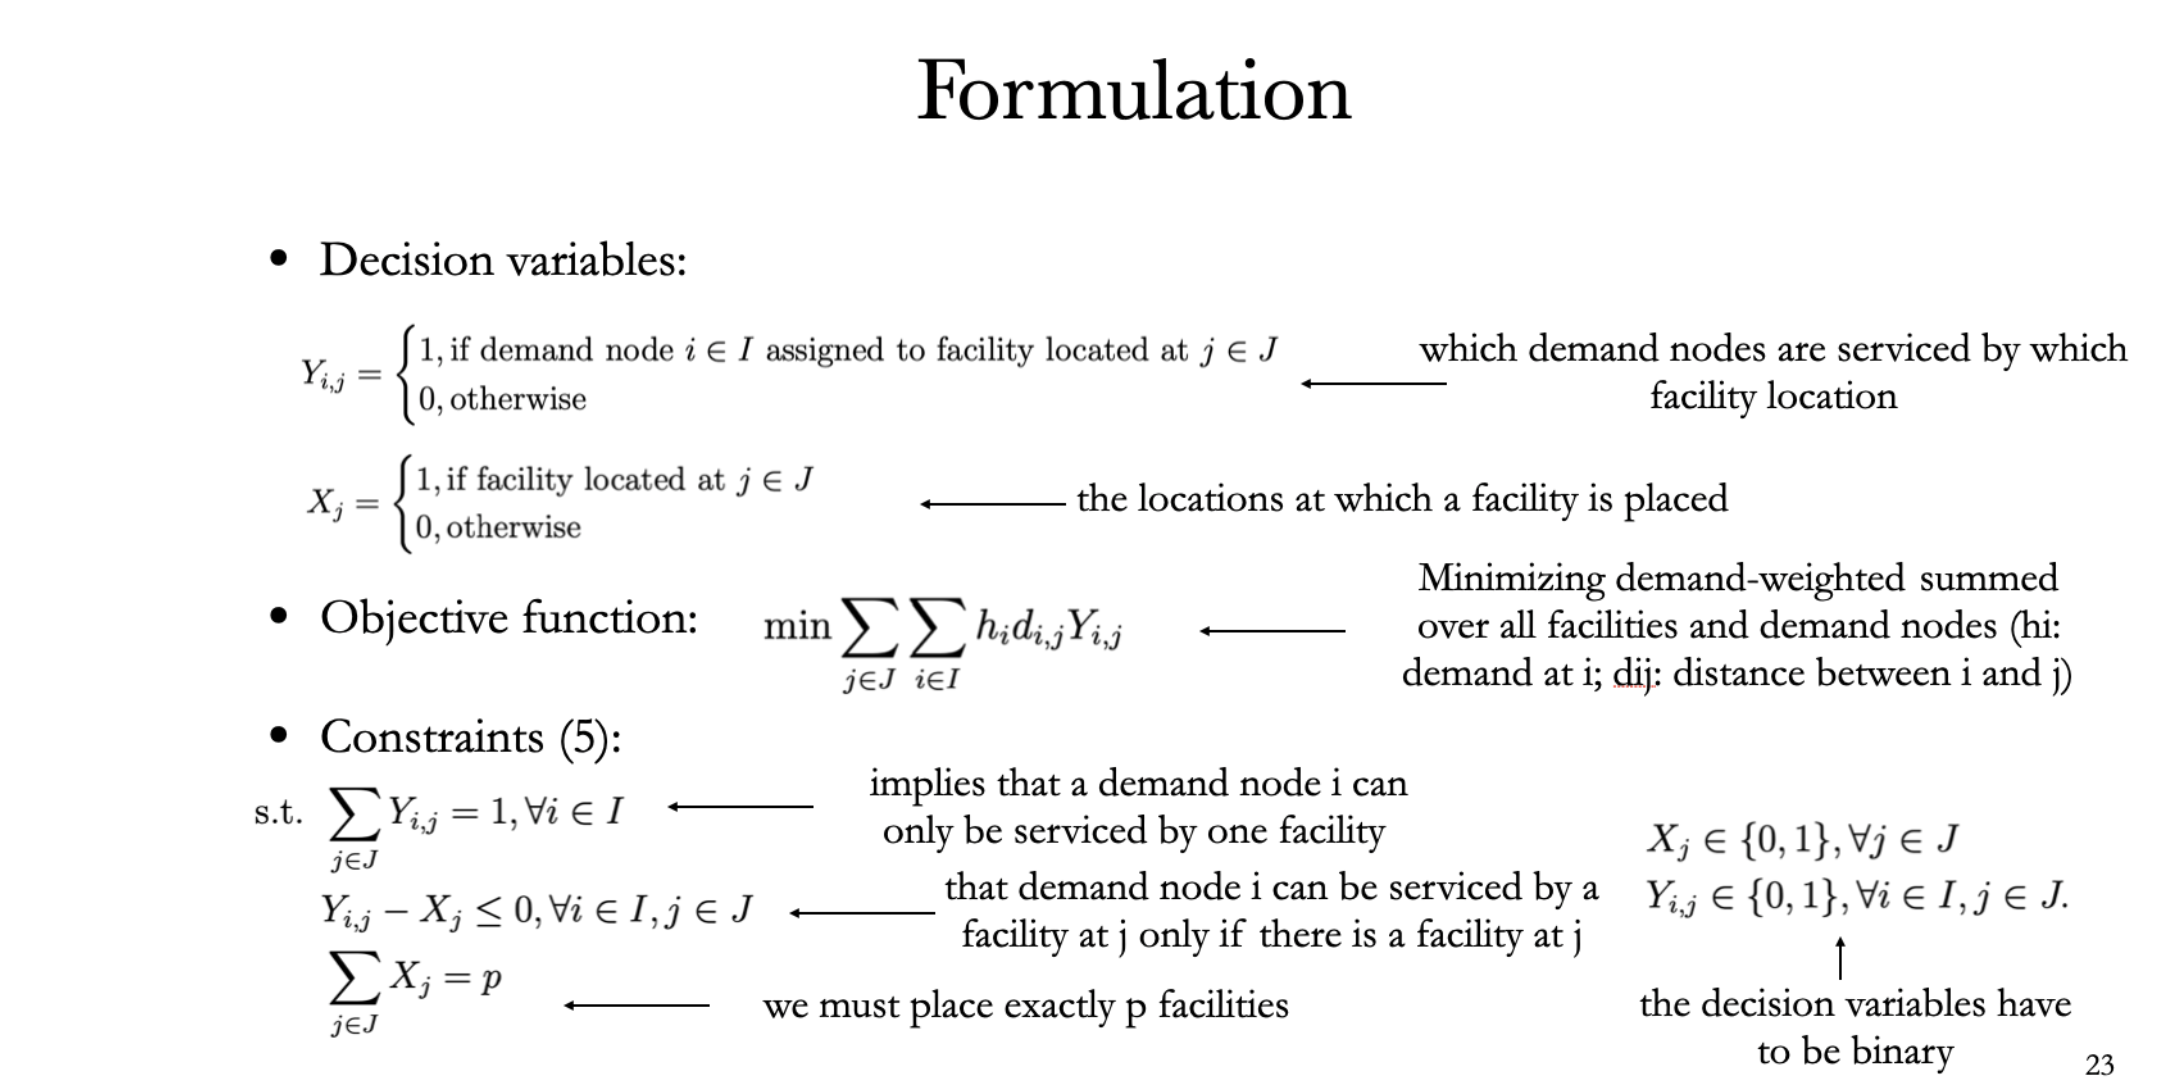

In [16]:
chi_comm_pop = gpd.read_file('./data/chicago_comm_pop/chicago_comm_pop.shp')

In [17]:
chi_comm_pop.head()

,GeoKey,Total_Pop,geometry
0,35,18238,"POLYGON ((-9752604.951 5137743.450, -9752605.8..."
1,36,5918,"POLYGON ((-9750713.852 5133595.674, -9750731.1..."
2,37,2876,"POLYGON ((-9754793.199 5131350.020, -9754792.7..."
3,38,21929,"POLYGON ((-9752334.139 5133578.410, -9752333.7..."
4,39,17841,"POLYGON ((-9750713.852 5133595.674, -9750713.4..."


In [18]:
#create demand and potential facility nodes
demand = np.arange(0,77,1)
facilities = np.arange(0,77,1)

In [20]:
#create a distance matrix
coords = list(zip(chi_comm_pop.centroid.x,chi_comm_pop.centroid.y))
d = cdist(coords,coords) 

In [21]:
#here we use demand as the total population
h = chi_comm_pop.Total_Pop.values

In [22]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary')

let's assume that we want to have 5 departments - change *p* if you want to build more or less

In [23]:
p = 5

prob = LpProblem('P_Median', LpMinimize)

Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 

h_i: demand at *i*; *d_ij*: distance between *i* and *j*

In [24]:
prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [25]:
prob += sum([X[j] for j in facilities]) == p

This constraint implies that a demand node *i* can only be serviced by one facility

In [26]:
for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1

This constraint implies that that demand node *i* can be serviced by a facility at *j* only if there is a facility at *j*. It implicitly removes situation when node *i* is served by *j* but there is no facility at *j*. 

In [27]:
for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [28]:
%%time

prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 153 ms, sys: 49 ms, total: 203 ms
Wall time: 534 ms


In [29]:
print("Objective: ",value(prob.objective))

Objective:  14217783986.21611


In [30]:
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  18
Facility Node:  24
Facility Node:  39
Facility Node:  5
Facility Node:  60


In [31]:
fac_loc = chi_comm_pop.iloc[rslt,:]

<AxesSubplot:>

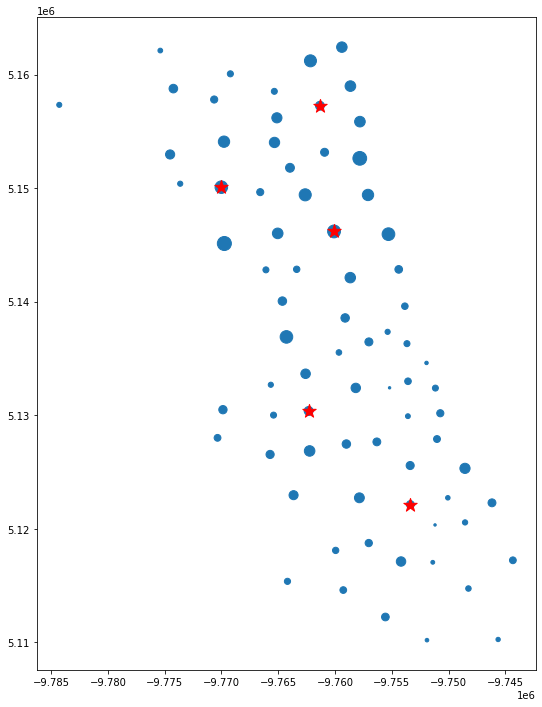

In [32]:
fig, ax = plt.subplots(figsize=(12,12))

chi_comm_pop.centroid.plot(ax=ax,markersize=chi_comm_pop.Total_Pop/500) # marker size is proportional to the population
fac_loc.centroid.plot(ax=ax,color="red",markersize=200,marker="*")

In [33]:
from shapely.geometry import LineString, MultiLineString
lines = []
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        left, right = (int(subV[1]), int(subV[2]))
        line = LineString([chi_comm_pop.iloc[left,:].geometry.centroid, chi_comm_pop.iloc[right,:].geometry.centroid])
        lines.append(line)
gdf_lines = gpd.GeoDataFrame(geometry=lines)

(-9791764.037241032, -9740827.057254149, 5105054.073132936, 5167258.616755508)

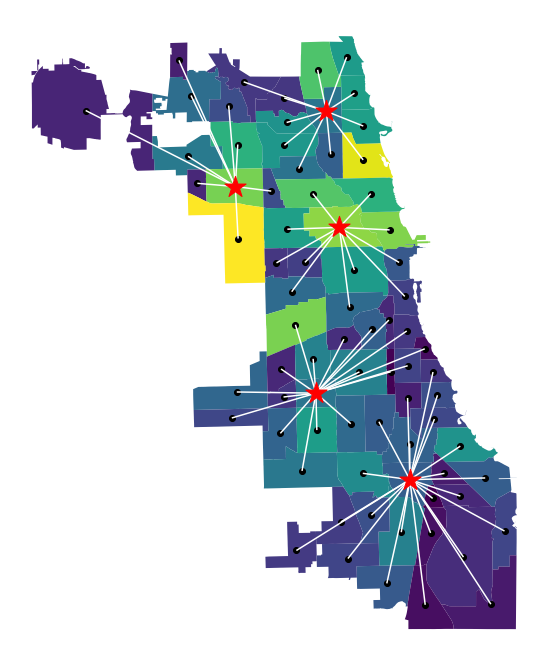

In [34]:
fig, ax = plt.subplots(figsize=(12,12))

chi_comm_pop.plot(ax=ax,column="Total_Pop") # markersize is proportional to the population
chi_comm_pop.centroid.plot(ax=ax,color="black")
gdf_lines.plot(ax=ax,color="white")
fac_loc.centroid.plot(ax=ax,color="red",markersize=500,marker="*",zorder=2)
plt.axis('off')